## 4.1

In [17]:
# setting up config

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_len": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [18]:
import torch
from torch import nn

In [19]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        b, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x


In [20]:
# tokenization step

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [21]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits, logits.shape)


tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>) torch.Size([2, 4, 50257])


## 4.2

In [22]:
# implementing Layer Norm
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(
    nn.Linear(batch_example.shape[-1], 6),
    nn.ReLU()
)
out = layer(batch_example)
print(out)

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(mean)
print(var)

out_norm = (out - mean)/torch.sqrt(var)
norm_mean = out_norm.mean(dim=-1, keepdim=True)
norm_var = out_norm.var(dim=-1, keepdim=True)
print(norm_mean)
print(norm_var)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [23]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x:torch.Tensor) -> torch.Tensor: 
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # reasoning for unbiased=False in notes
        norm_x = (x - mean)/torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [24]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print(mean)
print(var)

tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 4.3

In [25]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5*x*(1 + torch.tanh(
            torch.sqrt(torch.tensor(2/torch.pi)) * (x + 0.044715 * torch.pow(x,3))
        ))

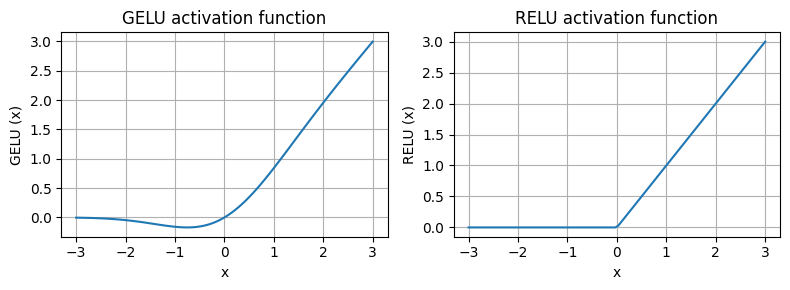

In [26]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3,3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

In [28]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,GPT_CONFIG_124M["emb_dim"]) #batch_size, num_tokens, emd_dim
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## 4.3

In [33]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i+1]),
                          GELU()) for i in range(len(layer_sizes)-1)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_out = layer(x)
            if self.use_shortcut and x.shape == layer_out.shape:
                x = x + layer_out # do not use x += layer_out as this concats layer_out instead of doing arithmetic addition
            else:
                x = layer_out
        return x

In [34]:
layer_sizes = [3,3,3,3,3,1]
sample_in = torch.tensor([1.,0.,-1.])
torch.manual_seed(123)

model_no_sc = ExampleDeepNeuralNetwork(layer_sizes, False)
model_sc = ExampleDeepNeuralNetwork(layer_sizes, True)

def print_gradients(model, x):
    out = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(out, target)
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} had gradient mean of {param.grad.abs().mean().item()}")

# more about named_parameters() in "pytorch misc notes".

# Suppose we have a 3 × 3 weight parameter matrix for a given layer. In that case, this layer will have
# 3 × 3 gradient values, and we print the mean absolute gradient of these 3 × 3 gradient
# values to obtain a single gradient value per layer to compare the gradients between layers more easily.
torch.manual_seed(123)
print("No shortcuts:")
print_gradients(model_no_sc, sample_in)
print("--------\nWith shortcuts:")
print_gradients(model_sc, sample_in)

No shortcuts:
layers.0.0.weight had gradient mean of 0.00020173587836325169
layers.1.0.weight had gradient mean of 0.0001201116101583466
layers.2.0.weight had gradient mean of 0.0007152041653171182
layers.3.0.weight had gradient mean of 0.001398873864673078
layers.4.0.weight had gradient mean of 0.005049646366387606
--------
With shortcuts:
layers.0.0.weight had gradient mean of 0.0014432319439947605
layers.1.0.weight had gradient mean of 0.004846962168812752
layers.2.0.weight had gradient mean of 0.0041389018297195435
layers.3.0.weight had gradient mean of 0.00591512955725193
layers.4.0.weight had gradient mean of 0.03265950828790665


## 4.5

In [39]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_len, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # reduces the projection dim to match the desired output dim
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Uses a Linear layer to combine all the outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_len, context_len), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(b, num_tokens, self.num_heads, self.head_dim) # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        K = K.view(b, num_tokens, self.num_heads, self.head_dim)
        V = V.view(b, num_tokens, self.num_heads, self.head_dim)

        Q = Q.transpose(1,2) # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        K = K.transpose(1,2)
        V = V.transpose(1,2)

        attn_scores = Q @ K.transpose(2,3)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / K.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vect = (attn_weights @ V).transpose(1,2) # (b, num_tokens, num_heads, head_dim)
        context_vect = context_vect.contiguous().view(b, num_tokens, self.d_out) # combines heads
        context_vect = self.out_proj(context_vect)
        return context_vect

In [40]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        self.mha = MultiHeadAttention(cfg["emb_dim"], cfg["emb_dim"], cfg["context_len"], cfg["drop_rate"], cfg["n_heads"], cfg["qkv_bias"])
        self.dropout_sc = nn.Dropout(cfg["drop_rate"])
        self.ff = FeedForward(cfg)

    def forward(self, x):
        sc = x
        x = self.norm1(x)
        x = self.mha(x)
        x = self.dropout_sc(x)
        x = x + sc

        sc = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout_sc(x)
        x = x + sc

        return x

In [ ]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)
print(x.shape, out.shape)

torch.Size([2, 4, 768]) torch.Size([2, 4, 768])
